In [1]:
import collections
import networkx as nx
import matplotlib.pyplot as plt
import highspy

In [2]:
def get_graph_from_file(input_file: str) -> nx.classes.graph.Graph:
    graph = nx.Graph()
    graph.add_edge(1, 2)
    with open(input_file, "r") as file:
        for line in file:
            words = line.rstrip("\n").split()
            if len(words) == 0:
                continue
            elif words[0] == "c":
                continue
            elif words[0] == "p":
                print(f"Graph with {words[2]} nodes and {words[3]} edges")
            elif words[0] == "e":
                from_node = int(words[1]) - 1
                to_node = int(words[2]) - 1
                graph.add_edge(from_node, to_node)

    return graph

In [3]:
class Model:
    def __init__(self, graph: nx.classes.graph.Graph):
        self.highs = highspy.Highs()
        self.nodes = sorted(list(graph.nodes))
        self.colors = self.nodes.copy()

        # 変数定義
        self.colorvars = {
            color: self.highs.addVar(lb=0, ub=1, type=highspy.HighsVarType.kInteger) for color in self.colors
        }
        self.nodecolor = {
            (node, color): self.highs.addVar(lb=0, ub=1, type=highspy.HighsVarType.kInteger)
            for node in self.nodes
            for color in self.colors
        }

        # 1 つのノードは 1 つの色で塗られる
        for node in self.nodes:
            self.highs.addConstr(sum([nc for (n, c), nc in self.nodecolor.items() if n == node]) == 1)

        # 隣り合うノードは同じ色で塗れない + 色採用
        for from_node, to_node in graph.edges:
            for color, colorvar in self.colorvars.items():
                self.highs.addConstr(
                    self.nodecolor[(from_node, color)]
                    + self.nodecolor[(to_node, color)]
                    <= colorvar
                )

        # 推奨らしい
        for color, colorvar in self.colorvars.items():
            self.highs.addConstr(
                colorvar <= sum([self.nodecolor[(node, color)] for node in self.nodes])
            )
        for i in self.colorvars:
            if i + 1 == len(self.colorvars):
                continue
            self.highs.addConstr(self.colorvars[i] >= self.colorvars[i + 1])

    def solve(self) -> int:
        # 使われた色の数を最小化
        self.highs.minimize(sum(self.colorvars.values()))

In [4]:
input_file = "data/test.txt"
# input_file = "data/queen7_7.col"
graph = get_graph_from_file(input_file)
for from_node, to_node in graph.edges:
    print(f"{from_node} -> {to_node}")

Graph with 10 nodes and 15 edges
1 -> 2
1 -> 0
1 -> 6
2 -> 3
2 -> 7
0 -> 4
0 -> 5
3 -> 4
3 -> 8
4 -> 9
5 -> 7
5 -> 8
6 -> 9
6 -> 8
7 -> 9


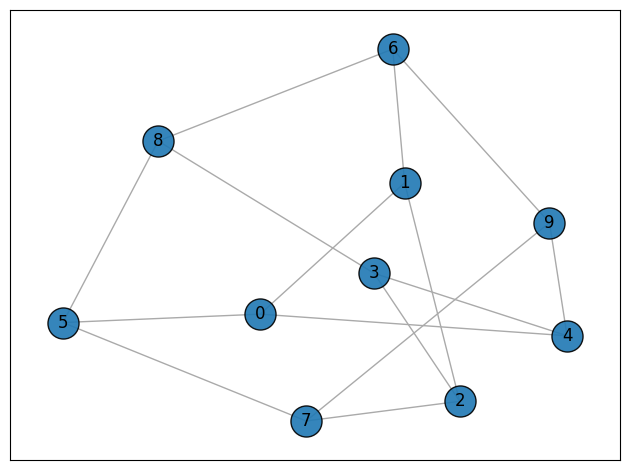

In [5]:
pos = nx.spring_layout(graph, seed=0)
nx.draw_networkx_nodes(
    graph,
    pos,
    node_size=500,
    # node_color=draw_nodecolor,
    # cmap=cmap,
    alpha=0.9,
    edgecolors="#000000",
)
nx.draw_networkx_edges(graph, pos, edge_color="#aaaaaa")
nx.draw_networkx_labels(graph, pos)
plt.tight_layout()
plt.show()

In [6]:
model = Model(graph)
model.highs.setOptionValue("time_limit", 300)
model.solve()

Running HiGHS 1.7.0 (git hash: 27ccfaa): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [1e+00, 1e+00]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 1e+00]
Presolving model
179 rows, 110 cols, 678 nonzeros  0s
177 rows, 108 cols, 642 nonzeros  0s
Objective function is integral with scale 1

Solving MIP model with:
   177 rows
   108 cols (108 binary, 0 integer, 0 implied int., 0 continuous)
   642 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   2               inf                  inf        0      0      0         0     0.0s
         0       0         0   0.00%   2               inf                  inf        0      0     14        92     0.0s

Solving report
  Status            Optimal
  Prim

In [7]:
solution = model.highs.getSolution()
info = model.highs.getInfo()
model_status = model.highs.getModelStatus()
print('Model status = ', model.highs.modelStatusToString(model_status))
print('Optimal objective = ', info.objective_function_value)
print('Iteration count = ', info.simplex_iteration_count)

Model status =  Optimal
Optimal objective =  3.0
Iteration count =  228


In [8]:
used_colors = collections.Counter(
    [
        color
        for color, colorvar in model.colorvars.items()
#        if solver.boolean_value(colorvar)
        if solution.col_value[:len(model.colors)][color] >= 0.99
    ]
)
for idx, used_color in enumerate(used_colors):
    used_colors[used_color] = idx

node_color = {}
for idx, (node, color) in enumerate(model.nodecolor):
    if solution.col_value[len(model.colors):][idx] >= 0.99:
        node_color[node] = used_colors[color]

for node in model.nodes:
    print(f"node {node}: color {node_color[node]}")

node 0: color 0
node 1: color 1
node 2: color 2
node 3: color 1
node 4: color 2
node 5: color 1
node 6: color 0
node 7: color 0
node 8: color 2
node 9: color 1


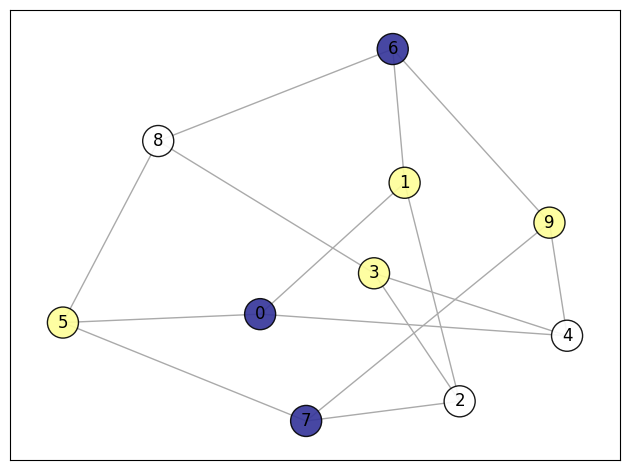

In [9]:
cmap = plt.get_cmap("terrain")
draw_colors = [i / (len(used_colors) - 1) for i in used_colors.values()]
draw_nodecolor = [draw_colors[node_color[node]] for node in graph.nodes]

pos = nx.spring_layout(graph, seed=0)
nx.draw_networkx_nodes(
    graph,
    pos,
    node_size=500,
    node_color=draw_nodecolor,
    cmap=cmap,
    alpha=0.9,
    edgecolors="#000000",
)
nx.draw_networkx_edges(graph, pos, edge_color="#aaaaaa")
nx.draw_networkx_labels(graph, pos)
plt.tight_layout()
plt.show()